In [1]:
import pandas as pd
import numpy as np
import time
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import ray
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import pickle
%matplotlib inline

In [4]:
# Read AUDUSD data file
raw_data = pd.read_csv("/home/ujwal/ML_program/Trading_financial_market/Predicting_AUDUSD_Using_Major_Regression_Models/AUDUSD_Candlestick_1_Hour_BID_03.09.2007-01.10.2022.csv")
raw_data

,Gmt time,Open,High,Low,Close,Volume
0,03.09.2007 00:00:00.000,0.82127,0.82207,0.82057,0.82157,184.95
1,03.09.2007 01:00:00.000,0.82147,0.82287,0.82097,0.82237,310.37
2,03.09.2007 02:00:00.000,0.82227,0.82367,0.82187,0.82267,419.97
3,03.09.2007 03:00:00.000,0.82287,0.82387,0.82157,0.82327,367.18
4,03.09.2007 04:00:00.000,0.82337,0.82387,0.82127,0.82157,257.45
...,...,...,...,...,...,...
132187,01.10.2022 19:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132188,01.10.2022 20:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132189,01.10.2022 21:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00
132190,01.10.2022 22:00:00.000,0.64023,0.64023,0.64023,0.64023,0.00


In [5]:
# drop everything except Time and Close information

clean_data = raw_data.drop(["High", "Open", "Low", "Volume"], axis=1)
df = clean_data.set_index('Gmt time')
df
#plot()

,Close
Gmt time,
03.09.2007 00:00:00.000,0.82157
03.09.2007 01:00:00.000,0.82237
03.09.2007 02:00:00.000,0.82267
03.09.2007 03:00:00.000,0.82327
03.09.2007 04:00:00.000,0.82157
...,...
01.10.2022 19:00:00.000,0.64023
01.10.2022 20:00:00.000,0.64023
01.10.2022 21:00:00.000,0.64023


<AxesSubplot:xlabel='Gmt time'>

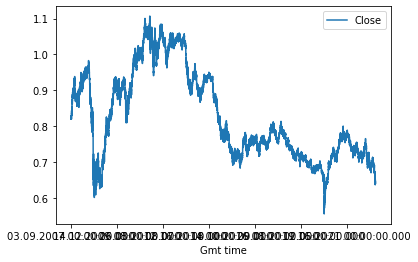

In [6]:
df.plot()

In [7]:
sum_inf = np.isinf(df).values.sum()
sum_nan = df.isna().sum()
print("number of inf value present =", sum_inf)
print("number of nan value present =", sum_nan)

number of inf value present = 0
number of nan value present = Close    0
dtype: int64


In [8]:
# visually data is non stationary
# Lets do Dickey-fuller test for conformation
# if P<0.05 && adf<-3.96 than data is stationary or it is not stationary
from statsmodels.tsa.stattools import adfuller
#adftest = adfuller(df1)
#print('pvalue of adfuller test is: ', adftest[1])

result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.273041097377704
p-value: 0.6414140450095792
Critial Values:
   1%, -3.430399488625976
Critial Values:
   5%, -2.8615618732559716
Critial Values:
   10%, -2.566781642358542


/n


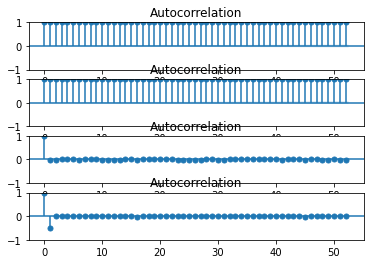

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
plot_acf(df, ax=ax1);
log_df = np.log(df)
plot_acf(log_df, ax= ax2);
plot_acf(log_df.diff().dropna(), ax=ax3);
plot_acf(log_df.diff().diff().dropna(), ax=ax4);

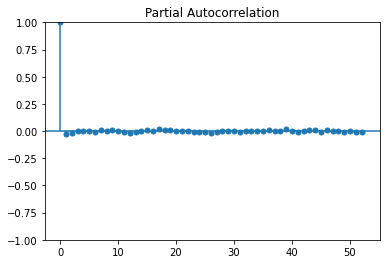

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(log_df.diff().dropna(), method='ywm');

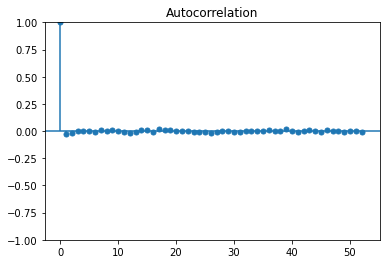

In [19]:
plot_acf(log_df.Close.diff().dropna());


In [24]:
# Lets do Dickey-fuller test for conformation
# if P<0.05 && adf<-3.96 than data is stationary or it is not stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_df.diff().dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -42.21846547908179
p-value: 0.0
Critial Values:
   1%, -3.430399496866874
Critial Values:
   5%, -2.861561876898299
Critial Values:
   10%, -2.566781644297229


In [25]:
print(len(df))
print("train=",len(df)*0.85)
print("test=", len(df)*0.15)

132192
train= 112363.2
test= 19828.8


In [26]:
# Split dataset to train, val, test as 70%-15%-15%
train, test = df[:112363], df[112363:] 
print(len(train), len(test))

112363 19829


In [27]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

model=sm.tsa.ARIMA(train, order=(1,1,1))
arima = model.fit()
pred=arima.predict(start=len(train),end=(len(df)-1))
mae=np.sqrt(mean_squared_error(test,pred))
mae

/home/ujwal/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ujwal/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ujwal/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ujwal/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/

0.0526319964290766

In [23]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:               112363
Model:                 ARIMA(1, 1, 1)   Log Likelihood              595929.543
Date:                Sun, 04 Dec 2022   AIC                       -1191853.085
Time:                        23:32:17   BIC                       -1191824.197
Sample:                             0   HQIC                      -1191844.364
                             - 112363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5044      0.001    910.780      0.000       0.503       0.506
ma.L1         -0.5270      0.001   -937.372      0.000      -0.528      -0.526
sigma2      1.448e-06   1.41e-09   1030.055      0.0

In [28]:
# Unused test dataset
print("Test data")
print("MAE=", mae, "\n")

Test data
MAE= 0.0526319964290766 



In [65]:
Test = np.array(test['Close'])
Test.shape

(19829,)

In [66]:
preds = np.array(pred)
# predicted = preds.reshape(-1,1)
preds.shape
preds.shape

(19829,)

In [67]:
mae=np.sqrt(mean_squared_error(Test,preds))
mae

0.0526319964290766

Text(0, 0.5, 'Predicted')

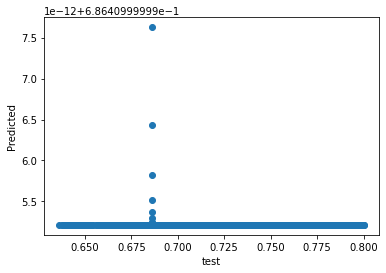

In [71]:
import matplotlib.pyplot as plt
plt.scatter(Test,preds)
plt.xlabel('test')
plt.ylabel('Predicted')

In [69]:
# Check mse using Linear regression
from sklearn import metrics
print('MAE :'," ", metrics.mean_absolute_error(Test,preds))
print('MSE :'," ", metrics.mean_squared_error(Test,preds))
print('RMSE :'," ", np.sqrt(metrics.mean_squared_error(Test,preds)))

MAE :   0.04525232084741661
MSE :   0.002770127048110332
RMSE :   0.0526319964290766


/home/ujwal/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

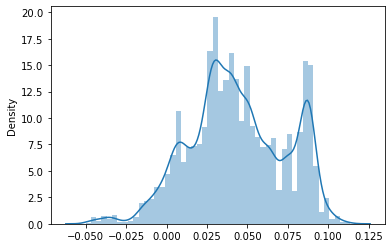

In [73]:
sns.distplot(Test - preds, bins=50)

In [74]:
# save model using pickle
import pickle
pickle.dump(arima, open('Arima.pkl', 'wb'))